## Kmeans

##### 1.聚类

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.base import clone
import pickle
import warnings

warnings.filterwarnings("ignore")

from sklearn.utils import check_random_state

# 设置随机种子
np.random.seed(33)
random_state = check_random_state(33)

# Custom scoring function for silhouette score
def silhouette_score_func(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# 读取数据
data = pd.read_excel('../../0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /table/校正并标准化后的患者行为变量数据.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc',
                 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

kmeans_param_grid = {
    'n_clusters': [2, 8],  # 默认是 8
    'init': ['k-means++'],  # 默认是 'k-means++'
    'random_state': [2024]  # 默认是 None
}

# 创建字典以保存每个聚类数量条件下的最佳参数和评分
best_params_scores = {}

# 稳定性分析
num_subsamples = 100
subsample_size = int(0.9 * len(EFs_data))

# 设置重复交叉验证的参数
n_splits = 10
n_repeats = 10
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

for n_clusters in range(2, 8):
    print(f"Running grid search for n_clusters = {n_clusters}")
    
    # 创建GridSearchCV对象, 使用自定义的评估指标作为scoring函数, 并使用重复交叉验证
    kmeans_grid_search = GridSearchCV(KMeans(n_clusters=n_clusters), 
                                      {k: v for k, v in kmeans_param_grid.items() if k != 'n_clusters'}, 
                                      cv=rkf,
                                      scoring=silhouette_score_func,
                                      refit=True, n_jobs=-1, verbose=0)

    # 运行网格搜索
    kmeans_grid_search.fit(EFs_data)
    
    # 获取最佳参数和评分
    kmeans_best_params = kmeans_grid_search.best_params_
    kmeans_best_score = kmeans_grid_search.best_score_
    
    # 获取平均silhouette score和标准差
    mean_silhouette_score = kmeans_grid_search.cv_results_['mean_test_score'][kmeans_grid_search.best_index_]
    std_silhouette_score = kmeans_grid_search.cv_results_['std_test_score'][kmeans_grid_search.best_index_]
    
    # 获取最佳模型的聚类中心
    best_cluster_centers = kmeans_grid_search.best_estimator_.cluster_centers_
    
    # 稳定性分析
    stabilities = []
    for _ in range(num_subsamples):
        subsample_indices = np.random.choice(len(EFs_data), subsample_size, replace=False)
        subsample_data = EFs_data.iloc[subsample_indices]
        
        subsample_kmeans = clone(kmeans_grid_search.best_estimator_)
        subsample_kmeans.fit(subsample_data)
        subsample_labels = subsample_kmeans.predict(subsample_data)
        
        full_data_labels = kmeans_grid_search.best_estimator_.predict(EFs_data)
        subsample_full_labels = full_data_labels[subsample_indices]
        
        stability = adjusted_rand_score(subsample_labels, subsample_full_labels)
        stabilities.append(stability)
    
    mean_stability = np.mean(stabilities)
    std_stability = np.std(stabilities)
    
    best_params_scores[n_clusters] = {
        'best_params': kmeans_best_params,
        'best_score': kmeans_best_score,
        'mean_silhouette_score': mean_silhouette_score,
        'std_silhouette_score': std_silhouette_score,
        'mean_stability': mean_stability,
        'std_stability': std_stability,
        'cluster_centers': best_cluster_centers  # 添加聚类中心
    }

    print(f"K-Means Best parameters for n_clusters = {n_clusters}: {kmeans_best_params}")
    print(f"K-Means Best silhouette score for n_clusters = {n_clusters}: {kmeans_best_score:.3f}")
    print(f"K-Means Mean silhouette score for n_clusters = {n_clusters}: {mean_silhouette_score:.3f}±{std_silhouette_score:.3f}")
    print(f"Mean stability for n_clusters = {n_clusters}: {mean_stability:.3f}±{std_stability:.3f}")
    
# 将best_params_scores字典保存到文件
with open('pkl/best_params_scores.pkl', 'wb') as f:
    pickle.dump(best_params_scores, f)

# 打印稳定性结果
print("Stability Results:")
for n_clusters, results in best_params_scores.items():
    print(f"n_clusters = {n_clusters}: Mean Stability = {results['mean_stability']:.3f} ± {results['std_stability']:.3f}")

Running grid search for n_clusters = 2
K-Means Best parameters for n_clusters = 2: {'init': 'k-means++', 'random_state': 2024}
K-Means Best silhouette score for n_clusters = 2: 0.609
K-Means Mean silhouette score for n_clusters = 2: 0.609±0.094
Mean stability for n_clusters = 2: 1.000±0.000
Running grid search for n_clusters = 3
K-Means Best parameters for n_clusters = 3: {'init': 'k-means++', 'random_state': 2024}
K-Means Best silhouette score for n_clusters = 3: 0.592
K-Means Mean silhouette score for n_clusters = 3: 0.592±0.083
Mean stability for n_clusters = 3: 0.760±0.149
Running grid search for n_clusters = 4
K-Means Best parameters for n_clusters = 4: {'init': 'k-means++', 'random_state': 2024}
K-Means Best silhouette score for n_clusters = 4: 0.539
K-Means Mean silhouette score for n_clusters = 4: 0.539±0.095
Mean stability for n_clusters = 4: 0.642±0.199
Running grid search for n_clusters = 5
K-Means Best parameters for n_clusters = 5: {'init': 'k-means++', 'random_state': 202

##### 2.保存最优参数的聚类标签

In [2]:
# 使用最优参数训练K-Means模型
best_n_clusters = max(best_params_scores, key=lambda x: best_params_scores[x]['best_score'])
best_params = best_params_scores[best_n_clusters]['best_params']
best_score = best_params_scores[best_n_clusters]['best_score']

print(f"最优聚类数量: {best_n_clusters}")
print(f"最优参数: {best_params}")
print(f"最优聚类数量下的最佳轮廓系数: {best_score:.3f}")

kmeans = KMeans(n_clusters=best_n_clusters, **best_params)
labels = kmeans.fit_predict(EFs_data)

# 将聚类结果添加到原始数据框
data['Cluster'] = labels

# 将聚类结果保存到新的Excel文件
output_file = 'EFs_data_with_clusters.xlsx'
data.to_excel(output_file, index=False)
print("保存成功！")



最优聚类数量: 2
最优参数: {'init': 'k-means++', 'random_state': 2024}
最优聚类数量下的最佳轮廓系数: 0.609
保存成功！


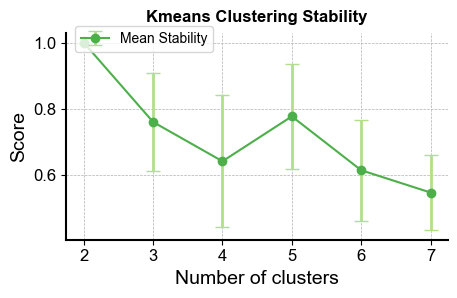

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# 设置字体大小和样式
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
})

# Nature风格配色方案
stability_line_color = '#4daf4a'  # 深绿色
stability_error_color = '#b2df8a'  # 浅绿色

# 从best_params_scores字典中提取数据
n_clusters_range = list(best_params_scores.keys())
stabilities = [best_params_scores[k]['mean_stability'] for k in n_clusters_range]
stability_std = [best_params_scores[k]['std_stability'] for k in n_clusters_range]

# 创建一个图表
fig, ax = plt.subplots(figsize=(4.8, 3.2), facecolor='w')

# 绘制稳定性
ax.errorbar(n_clusters_range, stabilities, yerr=stability_std, fmt='-o', capsize=5, color=stability_line_color, ecolor=stability_error_color, elinewidth=2, capthick=1, label='Mean Stability')

# 设置标题和标签
ax.set_title('Kmeans Clustering Stability', fontsize=12, weight='bold', pad=8)
ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_facecolor('w')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# 加粗X和Y轴线条,并设置为灰色
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# 添加图例，并设置位置和字体大小
ax.legend(loc='upper right', fontsize=10, bbox_to_anchor=(0.42, 1.1), borderaxespad=1.)

# 保存图表为高分辨率JPEG文件
fig.tight_layout()
fig.savefig('./image/stability_nature_style_plot.jpg', dpi=1200, format='jpg', bbox_inches='tight')

# 显示图形
plt.show()

##### 3.聚类结果可视化

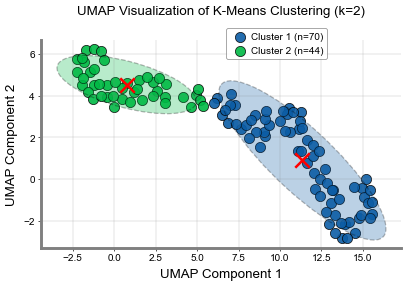

In [6]:
import umap.umap_ as umap
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Assuming best_params_scores is already defined in your environment

# Select the best number of clusters based on the best score
best_n_clusters = max(best_params_scores, key=lambda x: best_params_scores[x]['best_score'])
best_params = best_params_scores[best_n_clusters]['best_params']

# Train K-Means model using the best parameters
kmeans = KMeans(n_clusters=best_n_clusters, **best_params)
labels = kmeans.fit_predict(EFs_data)

# Add the cluster labels to the original data
data['Cluster'] = labels

# Use UMAP to reduce the data to 2 dimensions for visualization
umap_reducer = umap.UMAP(n_components=2, n_neighbors=40, min_dist=0.65, random_state=24)
data_umap = umap_reducer.fit_transform(EFs_data)

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# Define Nature-style colors
colors = ['#0C5DA5', '#00B945']

# Combine the UMAP-reduced data with the cluster labels into a DataFrame
data_df = pd.DataFrame(data=data_umap, columns=['UMAP1', 'UMAP2'])
data_df['Cluster'] = labels

fig, ax = plt.subplots(figsize=((7, 5)), dpi=60)

# Add background grid
ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

for i in range(best_n_clusters):
    cluster_data = data_df[data_df['Cluster'] == i]
    ax.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'],
               c=colors[i % len(colors)], alpha=0.9, s=150,
               edgecolors='black', linewidths=0.9,
               label=f'Cluster {i+1} (n={len(cluster_data)})')
    
    # Calculate the ellipse parameters
    cov = np.cov(cluster_data[['UMAP1', 'UMAP2']].values, rowvar=False)
    mean = np.mean(cluster_data[['UMAP1', 'UMAP2']].values, axis=0)
    eigvals, eigvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 3.65 * np.sqrt(eigvals)
    
    # Add the ellipse to the plot with adjusted alpha for transparency and fill color
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor='black', fc=colors[i % len(colors)], lw=1.5, linestyle='--', alpha=0.28)
    ax.add_patch(ellipse)
    
    # Mark the centroid of the cluster
    ax.scatter(mean[0], mean[1],
               c='red', s=300, marker='x', linewidths=3)

ax.set_xlabel('UMAP Component 1', fontsize=16, labelpad=6)
ax.set_ylabel('UMAP Component 2', fontsize=16, labelpad=6)
ax.set_title(f'UMAP Visualization of K-Means Clustering (k={best_n_clusters})', fontsize=16, pad=30)

# Adjust X and Y tick label font size
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust the legend's position and style
legend = ax.legend(loc='center left', bbox_to_anchor=(0.5, 0.98), frameon=True, fontsize=12, handletextpad=0.1)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('gray')

# Bold and set the color of the X and Y axis lines
ax.spines['bottom'].set_linewidth(3.5)
ax.spines['left'].set_linewidth(3.5)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('./image/UMAP_Visualization_for_K-Means_Clustering_Optimized.jpg', dpi=1200, bbox_inches='tight')
plt.show()

##### 5.可视化聚类结果

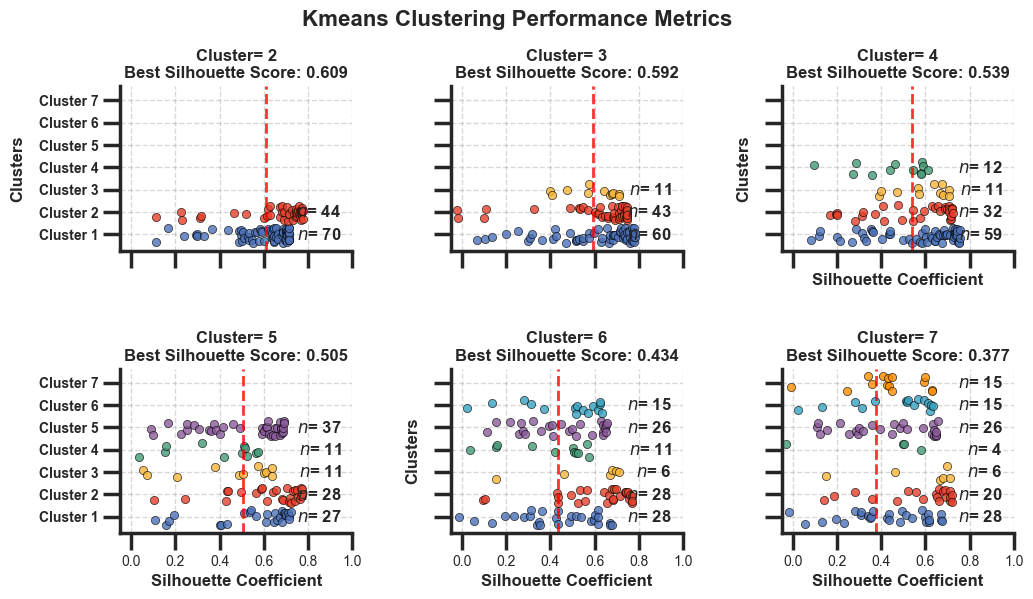

In [7]:
# 绘制聚类数量分析图
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns

plt.style.use('default')
sns.set_style("ticks")
sns.set_context("poster", font_scale=1.2)

fig, axs = plt.subplots(2, 3, figsize=(11, 7.5), sharex=True, sharey=True)
axs = axs.ravel()

colors = ['#4B71B8', '#E6402A', '#F7B538', '#449A76', '#8B5A9B', '#36A2C2', '#FF8C00', '#9BBB59', '#796FB2', '#F06292']

for i, n_clusters in enumerate(range(2, 8)):
    kmeans_best_params = best_params_scores[n_clusters]['best_params']
    kmeans_best_score = best_params_scores[n_clusters]['best_score']

    kmeans = KMeans(n_clusters=n_clusters, **kmeans_best_params)
    kmeans.fit(EFs_data)

    cluster_labels = kmeans.labels_
    sample_silhouette_values = silhouette_samples(EFs_data, cluster_labels)

    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_values = np.random.uniform(low=j-0.4, high=j+0.3, size=size_cluster_i)

        color = colors[j]
        axs[i].scatter(ith_cluster_silhouette_values, y_values, s=35, marker='o', facecolors=color, edgecolors='black', linewidth=0.5, alpha=0.8)
        axs[i].text(0.95, j, f"$n$= {size_cluster_i}", fontsize=12, ha='right', va='center', fontweight='bold', fontname='Arial')

    axs[i].set_title(f"Cluster= {n_clusters}\nBest Silhouette Score: {kmeans_best_score:.3f}", fontsize=12, fontweight='bold', fontname='Arial')
    axs[i].axvline(x=kmeans_best_score, color="red", linestyle="--", linewidth=2.0, alpha=0.8)
    axs[i].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axs[i].set_xlim([-0.05, 1.0])
    axs[i].set_yticks(range(n_clusters))
    axs[i].set_yticklabels([f"Cluster {j+1}" for j in range(n_clusters)], fontsize=10, fontweight='bold', fontname='Arial')
    axs[i].tick_params(labelsize=10)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

    # 添加背景格子
    axs[i].grid(which='major', axis='both', linestyle='--', linewidth=1.0, color='gray', alpha=0.3)

    if i % 2 == 0:
        axs[i].set_ylabel("Clusters", fontsize=12, labelpad=10, fontweight='bold', fontname='Arial')
    if i >= 2:
        axs[i].set_xlabel("Silhouette Coefficient", fontsize=12, fontweight='bold', fontname='Arial')
    axs[i].set_facecolor('white')

# 添加整体标题
plt.suptitle('Kmeans Clustering Performance Metrics', fontsize=16, fontweight='bold', fontname='Arial', y=0.86)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./image/Silhouette_Analysis_for_K-Means_Clustering_2_5_Nature_Revised_with_Grid_and_Labels_Scatter.jpg', dpi=1200, bbox_inches='tight', facecolor='white')
plt.show()

## 全部完成

In [8]:
print("全部完成！")

全部完成！
